In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import models,layers

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
emotion_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/fer2013.csv')

In [5]:
emotion_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


**Given pixels of each images is in string form!**

In [6]:
emotion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [7]:
emotion_df.shape

(35887, 3)

**Emotion label**<br>
0-Angry<br>
1-Disgust<br>
2-Fear<br>
3-Happy<br>
4-Sad<br>
5-Surprise<br>
6-Neutral


In [8]:
emotion_df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [10]:
#Lets remove Disgust and Fear label and make just  5 labels
drop_rows=emotion_df[(emotion_df.emotion==1) | (emotion_df.emotion==2)]
emotion_df=emotion_df.drop(drop_rows.index)

In [11]:
train_df=emotion_df[emotion_df['Usage']=='Training']
test_df=emotion_df[emotion_df['Usage']=='PrivateTest']

In [12]:
def split_x_y(df):
  x=[]
  img_pxl=df['pixels'].values
  for image in img_pxl:
      image=np.array(image.split(' '))
      image=(image.reshape(48,48,1)).astype('float')
      x.append(image)
  
  X=np.array(x)
  X=X/225
  Y=df['emotion'].values

  return X,Y

x_train,y_train=split_x_y(train_df)
x_test,y_test=split_x_y(test_df) 

In [13]:
y_train=pd.get_dummies(y_train).values
y_test_oh=pd.get_dummies(y_test).values

In [14]:
model=models.Sequential()
model.add(layers.Conv2D(64,(3,3),input_shape=(48,48,1)))
model.add(layers.Conv2D(64, (3, 3), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128,(3,3),padding='same'))
model.add(layers.Conv2D(128, (3, 3), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128,(3,3)))
model.add(layers.Conv2D(64, (3, 3), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256,(3,3),padding='same'))
model.add(layers.Conv2D(256,(3,3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
#model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5,activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       7

In [16]:
optimizer=tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
history=model.fit(x_train,y_train,batch_size=64,epochs=60,validation_data=(x_test,y_test_oh))

Epoch 1/60
378/378 [==============================] - 45s 32ms/step - loss: 1.5653 - accuracy: 0.2949 - val_loss: 1.4274 - val_accuracy: 0.3746
Epoch 2/60
378/378 [==============================] - 11s 29ms/step - loss: 1.2644 - accuracy: 0.4742 - val_loss: 1.1233 - val_accuracy: 0.5406
Epoch 3/60
378/378 [==============================] - 11s 29ms/step - loss: 1.1221 - accuracy: 0.5459 - val_loss: 1.1097 - val_accuracy: 0.5379
Epoch 4/60
378/378 [==============================] - 11s 29ms/step - loss: 1.0448 - accuracy: 0.5841 - val_loss: 1.0899 - val_accuracy: 0.5486
Epoch 5/60
378/378 [==============================] - 11s 29ms/step - loss: 0.9863 - accuracy: 0.6122 - val_loss: 1.1605 - val_accuracy: 0.5502
Epoch 6/60
378/378 [==============================] - 11s 30ms/step - loss: 0.9760 - accuracy: 0.6203 - val_loss: 1.0122 - val_accuracy: 0.5805
Epoch 7/60
378/378 [==============================] - 11s 30ms/step - loss: 0.9265 - accuracy: 0.6360 - val_loss: 0.9622 - val_accuracy:

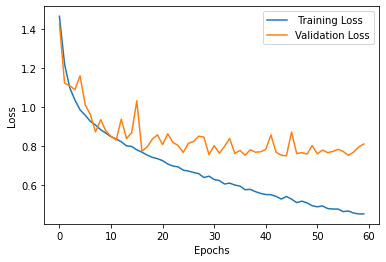

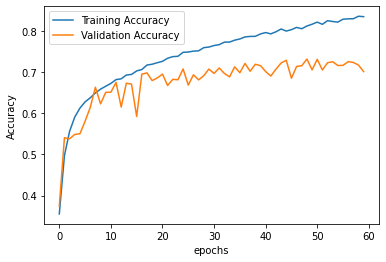

In [18]:
accuracy=history.history['accuracy']
loss=history.history['loss']
val_accuracy=history.history['val_accuracy']
val_loss=history.history['val_loss']
epochs=[x for x in range(len(accuracy))]
#plot Loss
plt.plot(epochs,loss,label=' Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plot Accuracy
plt.plot(epochs,accuracy,label='Training Accuracy')
plt.plot(epochs,val_accuracy,label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
model.evaluate(x_test,y_test_oh)

94/94 [==============================] - 1s 9ms/step - loss: 0.8117 - accuracy: 0.7009


[0.8117265105247498, 0.7009314894676208]

In [22]:
y_pred=model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [23]:
model.save('/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/fr_model.h5')